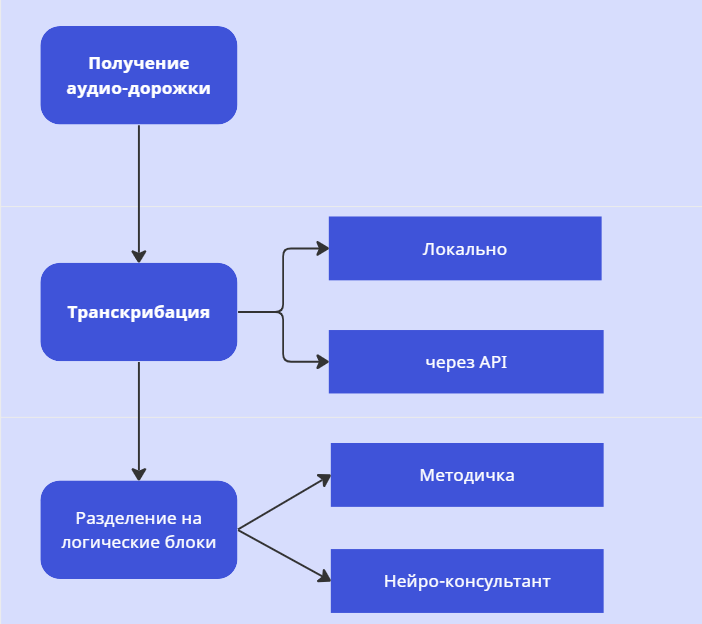

В данном ноутбуке мы на основании видео-лекции с ютуб создаем нейро-консультанта и методичку по основным моментам данной лекции. Для начала, получаем аудио-дорожку из видео, которую будем транскрибировать (переводить в текст) при помощи модели whisper от openAI:

# **СПОСОБ 1 без ключа**

Документацию можно посмотреть тут: https://github.com/openai/whisper

In [ ]:
# @title Устанавливаем whisper и yt-dlp
!pip -q install yt-dlp -U # Устанавливаем библиотеку для загрузки звука с видео. документация https://github.com/yt-dlp/yt-dlp?tab=readme-ov-file#readme
!pip install git+https://github.com/openai/whisper.git
from IPython.display import clear_output
clear_output()

In [ ]:
!pip install -q tiktoken==0.7.0 openai==1.41.1 langchain==0.2.14 langchain_community==0.2.12 langchain-openai==0.1.22 faiss-cpu==1.8.0 python-docx==1.1.0
from IPython.display import clear_output
clear_output()

In [ ]:
import whisper
import os
import gdown
import requests
import re
import time
from IPython.display import HTML, clear_output
import subprocess
from pathlib import Path
import json
import tiktoken
from docx import Document
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
import ipywidgets as widgets
from IPython.display import display
from tqdm.auto import tqdm
import getpass
import pickle
from urllib.request import urlopen
import openai
import subprocess
import codecs
from langchain.chains import ConversationChain         # Импортируем класс для создания цепочек диалогов
from langchain_openai import ChatOpenAI           # Импортируем класс для работы с чатами на базе OpenAI
from langchain_openai import OpenAI
from langchain.memory import ConversationBufferMemory  # Импортируем класс для управления памятью диалогов
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
import os
import glob
import shutil
import urllib

## Получение аудио-дорожки из видео по ссылке и загрузка в колаб

In [ ]:
import yt_dlp

# Ссылка на видео YouTube для скачивания
URLS = ['https://www.youtube.com/watch?v=KdZ4HF1SrFs']  # указываем ссылку для получения аудио-дорожки из видео

# Придумаем короткое имя для сохраняемого аудио файла на английском языке.
name = 'My_Audio'
file_name = f"download_{name}.m4a"

# Значения для получения лучшего качества звука из документации.
ydl_opts = {
    'format': 'm4a/bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'm4a',
    }],
    'outtmpl': file_name,
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    error_code = ydl.download(URLS)
    if error_code == 0:
        print('Загрузка файла прошла успешно!')
    else:
        print(f'Код ошибки: {error_code}')

print(f"\nАудиофайл загружен, имя файла: {file_name}")

[youtube] Extracting URL: https://www.youtube.com/watch?v=KdZ4HF1SrFs
[youtube] KdZ4HF1SrFs: Downloading webpage
[youtube] KdZ4HF1SrFs: Downloading ios player API JSON
[youtube] KdZ4HF1SrFs: Downloading web creator player API JSON
[youtube] KdZ4HF1SrFs: Downloading player 3abab6ef
[youtube] KdZ4HF1SrFs: Downloading m3u8 information
[info] KdZ4HF1SrFs: Downloading 1 format(s): 140
[download] Destination: download_My_Audio.m4a
[download] 100% of   74.85MiB in 00:00:02 at 25.32MiB/s  
[FixupM4a] Correcting container of "download_My_Audio.m4a"
[ExtractAudio] Not converting audio download_My_Audio.m4a; file is already in target format m4a
Загрузка файла прошла успешно!

Аудиофайл загружен, имя файла: download_My_Audio.m4a


In [ ]:
# выводим путь до скачанного файла
audio_file_path = file_name
audio_file_path

'download_My_Audio.m4a'

In [ ]:
# так можно посмотреть доступные параметры
!whisper --help

usage: whisper [-h] [--model MODEL] [--model_dir MODEL_DIR] [--device DEVICE]
               [--output_dir OUTPUT_DIR] [--output_format {txt,vtt,srt,tsv,json,all}]
               [--verbose VERBOSE] [--task {transcribe,translate}]
               [--language {af,am,ar,as,az,ba,be,bg,bn,bo,br,bs,ca,cs,cy,da,de,el,en,es,et,eu,fa,fi,fo,fr,gl,gu,ha,haw,he,hi,hr,ht,hu,hy,id,is,it,ja,jw,ka,kk,km,kn,ko,la,lb,ln,lo,lt,lv,mg,mi,mk,ml,mn,mr,ms,mt,my,ne,nl,nn,no,oc,pa,pl,ps,pt,ro,ru,sa,sd,si,sk,sl,sn,so,sq,sr,su,sv,sw,ta,te,tg,th,tk,tl,tr,tt,uk,ur,uz,vi,yi,yo,yue,zh,Afrikaans,Albanian,Amharic,Arabic,Armenian,Assamese,Azerbaijani,Bashkir,Basque,Belarusian,Bengali,Bosnian,Breton,Bulgarian,Burmese,Cantonese,Castilian,Catalan,Chinese,Croatian,Czech,Danish,Dutch,English,Estonian,Faroese,Finnish,Flemish,French,Galician,Georgian,German,Greek,Gujarati,Haitian,Haitian Creole,Hausa,Hawaiian,Hebrew,Hindi,Hungarian,Icelandic,Indonesian,Italian,Japanese,Javanese,Kannada,Kazakh,Khmer,Korean,Lao,Latin,Latvian,Le

In [ ]:
# Используем Whisper для обработки аудиофайла
%%time
!whisper '/content/download_My_Audio.m4a' --model large --language ru --output_format txt

100%|█████████████████████████████████████| 2.88G/2.88G [00:41<00:00, 74.0MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

In [ ]:
# Задаем путь к файлу
file_path = '/content/download_My_Audio.txt'

# Открываем файл и читаем его содержимое
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        print(content)
except FileNotFoundError:
    print(f'Файл не найден: {file_path}')

Здравствуйте! Рад вас приветствовать в стенах Московского физико-технического института.
Половина присутствующих здесь первокурсники.
Я сердечно рад вас поздравить с поступлением на физтех.
Поздравляю вас!
Меня зовут Тимофей Федорович Хирьянов.
Я буду с вами полтора года в качестве лектора по информатике.
И первый наш курс – это такое путешествие длиной в год.
Как мы видим, я имею в виду кафедру информатики МФТИ, как мы видим информатику?
Дело в том, что информатика – это не наука.
Информатика – это школьный предмет или вузовский предмет, который является интегральным.
В него входит много всего.
В частности, туда входит…
Входит умение пользоваться компьютером.
То есть навыки работы с прикладными программами.
Печатать в офисе, всякие специализированные программки, условный фотошоп, гимб, что-нибудь там, корлдро и прочее.
Системное администрирование туда входит.
Сетевые технологии, сисадмин локальный, как компьютер, операционку установить и прочее.
От вирусов компьютер пошел.
И сетевые в

# **СПОСОБ 2 с ключом**

Официальную документацию можно посмотреть тут: https://platform.openai.com/docs/guides/speech-to-text

In [ ]:
!pip -q install yt-dlp -U # Устанавливаем библиотеку для загрузки звука с видео. документация https://github.com/yt-dlp/yt-dlp?tab=readme-ov-file#readme

In [ ]:
!pip install -q pydub==0.25.1 tiktoken==0.7.0 openai==1.41.1 langchain==0.2.14 langchain_community==0.2.12 langchain-openai==0.1.22 faiss-cpu==1.8.0 langchain-text-splitters pytube==15.0.0
from IPython.display import clear_output
clear_output()

In [ ]:
import getpass
import os
import subprocess
import openai
from google.colab import userdata
from pytube import YouTube
from pydub import AudioSegment
from openai import OpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter

In [ ]:
key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = key

Получаем аудио-файл со ссылки на Ютуб-видео

In [ ]:
import yt_dlp

# Ссылка на видео YouTube для скачивания
URLS = ['https://www.youtube.com/watch?v=Uqp-pzGMjlU']  # указываем ссылку для получения аудио-дорожки из видео

# Придумаем короткое имя для сохраняемого аудио файла на английском языке.
name = 'My_Audio_2'
file_name = f"download_{name}.m4a"

# Значения для получения лучшего качества звука из документации.
ydl_opts = {
    'format': 'm4a/bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'm4a',
    }],
    'outtmpl': file_name,
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    error_code = ydl.download(URLS)
    if error_code == 0:
        print('Загрузка файла прошла успешно!')
    else:
        print(f'Код ошибки: {error_code}')

print(f"\nАудиофайл загружен, имя файла: {file_name}")

[youtube] Extracting URL: https://www.youtube.com/watch?v=Uqp-pzGMjlU
[youtube] Uqp-pzGMjlU: Downloading webpage
[youtube] Uqp-pzGMjlU: Downloading ios player API JSON
[youtube] Uqp-pzGMjlU: Downloading web creator player API JSON
[youtube] Uqp-pzGMjlU: Downloading m3u8 information
[info] Uqp-pzGMjlU: Downloading 1 format(s): 140
[download] Destination: download_My_Audio_2.m4a
[download] 100% of   64.00MiB in 00:00:01 at 35.11MiB/s  
[FixupM4a] Correcting container of "download_My_Audio_2.m4a"
[ExtractAudio] Not converting audio download_My_Audio_2.m4a; file is already in target format m4a
Загрузка файла прошла успешно!

Аудиофайл загружен, имя файла: download_My_Audio_2.m4a


Транскрибируем аудио-файл при помощи модели whisper. В данном случае разделяем аудио-файл на сегменты, каждый сегмент транскрибируем и полученные тексты объединяем в один файл.

In [ ]:
# Инициализация клиента OpenAI
client = OpenAI()

def transcribe_audio_whisper_chunked(audio_path, file_title, save_folder_path, max_duration=5 * 60 * 1000):  # 5 минут
    """
    Функция для транскрибации аудиофайла на части, чтобы соответствовать ограничениям размера API.
    """

    # Создание папки для сохранения результатов, если она ещё не существует
    os.makedirs(save_folder_path, exist_ok=True)

    # Загрузка аудиофайла
    audio = AudioSegment.from_file(audio_path)

    # Создание временной папки для хранения аудио чанков (фрагментов)
    temp_dir = os.path.join(save_folder_path, "temp_audio_chunks")
    os.makedirs(temp_dir, exist_ok=True)

    # Инициализация переменных для обработки аудио чанков
    current_start_time = 0  # Текущее время начала чанка
    chunk_index = 1         # Индекс текущего чанка
    transcriptions = []     # Список для хранения всех транскрибаций

    # Обработка аудиофайла чанками
    while current_start_time < len(audio):
        # Выделение чанка из аудиофайла
        chunk = audio[current_start_time:current_start_time + max_duration]
        # Формирование имени и пути файла чанка
        chunk_name = f"chunk_{chunk_index}.wav"
        chunk_path = os.path.join(temp_dir, chunk_name)
        # Экспорт чанка в формате wav
        chunk.export(chunk_path, format="wav")

        # Проверка размера файла чанка на соответствие лимиту API
        if os.path.getsize(chunk_path) > 26214400:  # 25 MB
            print(f"Chunk {chunk_index} exceeds the maximum size limit for the API. Trying a smaller duration...")
            max_duration = int(max_duration * 0.9)  # Уменьшение длительности чанка на 10%
            os.remove(chunk_path)  # Удаление чанка, превышающего лимит
            continue

        # Открытие файла чанка для чтения в двоичном режиме
        with open(chunk_path, "rb") as src_file:
            print(f"Transcribing {chunk_name}...")
            try:
                # Запрос на транскрибацию чанка с использованием модели Whisper
                transcript_response = client.audio.transcriptions.create(
                    model="whisper-1",
                    file=src_file
                )
                # Добавление результата транскрибации в список транскрипций
                transcriptions.append(transcript_response.text)
            except openai.BadRequestError as e:
                print(f"An error occurred: {e}")
                break

        # Удаление обработанного файла чанка
        os.remove(chunk_path)
        # Переход к следующему чанку
        current_start_time += max_duration
        chunk_index += 1

    # Удаление временной папки с чанками
    os.rmdir(temp_dir)

    # Сохранение всех транскрипций в один текстовый файл
    result_path = os.path.join(save_folder_path, f"{file_title}.txt")
    with open(result_path, "w") as txt_file:
        txt_file.write("\n".join(transcriptions))

    print(f"Transcription saved to {result_path}")

In [ ]:
# Параметры файла и вызов функции
audio_path = '/content/download_My_Audio_2.m4a'
file_title = 'Graphs_Algorithms_and_Data_Structures_in_Python_Transcription'
save_folder_path = '/content/transcriptions/'

res = transcribe_audio_whisper_chunked(audio_path, file_title, save_folder_path)

Chunk 1 exceeds the maximum size limit for the API. Trying a smaller duration...
Chunk 1 exceeds the maximum size limit for the API. Trying a smaller duration...
Chunk 1 exceeds the maximum size limit for the API. Trying a smaller duration...
Chunk 1 exceeds the maximum size limit for the API. Trying a smaller duration...
Chunk 1 exceeds the maximum size limit for the API. Trying a smaller duration...
Chunk 1 exceeds the maximum size limit for the API. Trying a smaller duration...
Chunk 1 exceeds the maximum size limit for the API. Trying a smaller duration...
Transcribing chunk_1.wav...
Transcribing chunk_2.wav...
Transcribing chunk_3.wav...
Transcribing chunk_4.wav...
Transcribing chunk_5.wav...
Transcribing chunk_6.wav...
Transcribing chunk_7.wav...
Transcribing chunk_8.wav...
Transcribing chunk_9.wav...
Transcribing chunk_10.wav...
Transcribing chunk_11.wav...
Transcribing chunk_12.wav...
Transcribing chunk_13.wav...
Transcribing chunk_14.wav...
Transcribing chunk_15.wav...
Transcr

Итак, мы получили транскрибацию видео по ссылке с ютуб.

In [ ]:
# @title Установка и импорты
import shutil
from langchain.docstore.document import Document
from langchain_openai import OpenAI
from IPython.display import display, HTML

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [ ]:
#@title Разделяем текст на логические блоки с выделением названия раздела:
system = '\u0412\u044B \u0433\u0435\u043D\u0438\u0439 \u0442\u0435\u043A\u0441\u0442\u0430, \u043A\u043E\u043F\u0438\u0440\u0430\u0439\u0442\u0438\u043D\u0433\u0430, \u043F\u0438\u0441\u0430\u0442\u0435\u043B\u044C\u0441\u0442\u0432\u0430. \u0412\u0430\u0448\u0430 \u0437\u0430\u0434\u0430\u0447\u0430 \u0440\u0430\u0441\u043F\u043E\u0437\u043D\u0430\u0442\u044C \u0440\u0430\u0437\u0434\u0435\u043B\u044B \u0432 \u0442\u0435\u043A\u0441\u0442\u0435 \u0438 \u0440\u0430\u0437\u0431\u0438\u0442\u044C \u0435\u0433\u043E \u043D\u0430 \u044D\u0442\u0438 \u0440\u0430\u0437\u0434\u0435\u043B\u044B \u0441\u043E\u0445\u0440\u0430\u043D\u044F\u044F \u0432\u0435\u0441\u044C \u0442\u0435\u043A\u0441\u0442 \u043D\u0430 100%' #@param {type:"string"}
user = '\u041F\u043E\u0436\u0430\u043B\u0443\u0439\u0441\u0442\u0430, \u0434\u0430\u0432\u0430\u0439\u0442\u0435 \u043F\u043E\u0434\u0443\u043C\u0430\u0435\u043C \u0448\u0430\u0433 \u0437\u0430 \u0448\u0430\u0433\u043E\u043C: \u041F\u043E\u0434\u0443\u043C\u0430\u0439\u0442\u0435, \u043A\u0430\u043A\u0438\u0435 \u0440\u0430\u0437\u0434\u0435\u043B\u044B \u0432 \u0442\u0435\u043A\u0441\u0442\u0435 \u0432\u044B \u043C\u043E\u0436\u0435\u0442\u0435 \u0440\u0430\u0441\u043F\u043E\u0437\u043D\u0430\u0442\u044C \u0438 \u043A\u0430\u043A\u043E\u0435 \u043D\u0430\u0437\u0432\u0430\u043D\u0438\u0435 \u043F\u043E \u0441\u043C\u044B\u0441\u043B\u0443 \u043C\u043E\u0436\u043D\u043E \u0434\u0430\u0442\u044C \u043A\u0430\u0436\u0434\u043E\u043C\u0443 \u0440\u0430\u0437\u0434\u0435\u043B\u0443. \u0414\u0430\u043B\u0435\u0435 \u043D\u0430\u043F\u0438\u0448\u0438\u0442\u0435 \u043E\u0442\u0432\u0435\u0442 \u043F\u043E \u0432\u0441\u0435\u043C\u0443 \u043F\u0440\u0435\u0434\u044B\u0434\u0443\u0449\u0435\u043C\u0443 \u043E\u0442\u0432\u0435\u0442\u0443 \u0432 \u043F\u043E\u0440\u044F\u0434\u043A\u0435: ## \u041D\u0430\u0437\u0432\u0430\u043D\u0438\u0435 \u0440\u0430\u0437\u0434\u0435\u043B\u0430, \u043F\u043E\u0441\u043B\u0435 \u0447\u0435\u0433\u043E \u0432\u0435\u0441\u044C \u0442\u0435\u043A\u0441\u0442, \u043E\u0442\u043D\u043E\u0441\u044F\u0449\u0438\u0439\u0441\u044F \u043A \u044D\u0442\u043E\u043C\u0443 \u0440\u0430\u0437\u0434\u0435\u043B\u0443. \u0422\u0435\u043A\u0441\u0442:' #@param {type:"string"}

temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
chunk_size = 7000 #@param {type: "slider", min: 1000, max: 7000, step:500}

In [ ]:
# @title Функции
# Функция настройки стиля для переноса текста в выводе ячеек
# для изменения стиля отображения текста, так чтобы предотвратить переполнение текста за границы ячейки вывода и обеспечить его перенос.
def set_text_wrap_css():
    css = '''
    <style>
    pre {
        white-space: pre-wrap;
    }
    </style>
    '''
    display(HTML(css))

get_ipython().events.register('pre_run_cell', set_text_wrap_css)

# Функция подсчета количества токенов
def num_tokens_from_messages(messages, model='gpt-4o-mini'):
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        encoding = tiktoken.get_encoding('cl100k_base')

    if model in ['gpt-4o-mini', 'gpt-4o', 'gpt-4o-latest']:
        num_tokens = 0

        for message in messages:
            num_tokens += 4

            for key, value in message.items():
                num_tokens += len(encoding.encode(value))

                if key == 'name':
                    num_tokens -= 1

        num_tokens += 2
        return num_tokens

    else:
        raise NotImplementedError(f'''num_tokens_from_messages() is not presently implemented for model {model}.''')


# Функция дробления текста на чанки
def split_text(txt_file, chunk_size=chunk_size):
    source_chunks = []
    splitter = RecursiveCharacterTextSplitter(separators=['\n', '\n\n', '. '], chunk_size=chunk_size, chunk_overlap=0)

    for chunk in splitter.split_text(txt_file):
        source_chunks.append(Document(page_content=chunk, metadata={"meta":"data"}))

    print(f'\n\nТекст разбит на {len(source_chunks)} чанков.')

    return source_chunks


# Функция получения ответа от модели
def answer_index(system, user, chunk, temp=temperature, model='gpt-4o-mini'):

    messages = [
        {'role': 'system', 'content': system},
        {'role': 'user', 'content': user + f'{chunk}'}
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )

    # Вывод количества токенов отключен
    # print(f'\n====================\n\n{num_tokens_from_messages(messages)} токенов будет использовано на чанк\n\n')
    answer = completion.choices[0].message.content

    return answer


def process_one_file(file_path, system, user):
    with open(file_path, 'r') as txt_file:
        text = txt_file.read()
    source_chunks = split_text(text)
    processed_text = ''
    unprocessed_text = ''

    for chunk in source_chunks:
        attempt = 0

        while attempt < 3:
            try:
                answer = answer_index(system, user, chunk.page_content)
                break  # Успешно получили ответ, выходим из цикла попыток

            except Exception as e:
                attempt += 1  # Увеличиваем счетчик попыток
                print(f'\n\nПопытка {attempt} не удалась из-за ошибки: {str(e)}')
                time.sleep(10)  # Ожидаем перед следующей попыткой
                if attempt == 3:
                    answer = ''
                    print(f'\n\nОбработка элемента {chunk} не удалась после 3 попыток')
                    unprocessed_text += f'{chunk}\n\n'

        processed_text += f'{answer}\n\n'  # Добавляем ответ в результат
        print(f'{answer}')  # Выводим ответ

    return processed_text, unprocessed_text

In [ ]:
# @title Запуск
file_path = '/content/transcriptions/Graphs_Algorithms_and_Data_Structures_in_Python_Transcription.txt'
#file_path = '/content/transcriptions/Графы_Алгоритмы_и_Структуры_Данных_на_Python.txt'
# Вызываем функцию обработки для этого файла
processed_text, unprocessed_text = process_one_file(file_path, system, user)




Текст разбит на 8 чанков.
## Введение
you you you you you
Yn ôl ystod yr adeg, byddwn yn gysylltu ag eich cyfrifiadau. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr hwnnw. Yn ysbrydol, mae'r arian yma yn cael ei gysylltu â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr.

## Личное представление
Так, давайте еще раз. Говорят, звук должен быть. Тогда давайте еще раз. Всем привет. Меня зовут Иван. Последние 6 лет я занимаюсь задачей машинного обучения. Сейчас они уже невозможны, по сути, без знания компьютерных алгоритмов, компьютер-сайенс, алгоритмс. Поэтому сегодня мы разберем одну из тем, конкретно на графы. Надеюсь, это будет вам интересным. Немножко о себе. Я сейчас работаю в компании ShareChat на позиции став машинолог-инженер. До этого работа

Итак, мы получили текст транскрибации, разделенный на разделы с названиями данных разделов. Теперь разделим этот текст на чанки при помощи MarkdownHeaderTextSplitter, создадим из него векторную базу Faiss и сделаем нейро-консультанта, который отвечает на вопросы по тексту, а из текста транскрибации с разделами составим методичку.

In [ ]:
# Определяем заголовки, на которые следует разбить текст
headers_to_split_on = [
    ("##", "Header 2")
    ]
# Создаем объект для разбиения текста на секции по заголовкам
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

# Получаем список документов, разбитых по заголовкам
md_header_splits = markdown_splitter.split_text(processed_text)

In [ ]:
md_header_splits

[Document(metadata={'Header 2': 'Введение'}, page_content="you you you you you\nYn ôl ystod yr adeg, byddwn yn gysylltu ag eich cyfrifiadau. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr hwnnw. Yn ysbrydol, mae'r arian yma yn cael ei gysylltu â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr. Mae'r fframwyrwyr yn ymwneud â'r fframwyrwyr."),
 Document(metadata={'Header 2': 'Личное представление'}, page_content='Так, давайте еще раз. Говорят, звук должен быть. Тогда давайте еще раз. Всем привет. Меня зовут Иван. Последние 6 лет я занимаюсь задачей машинного обучения. Сейчас они уже невозможны, по сути, без знания компьютерных алгоритмов, компьютер-сайенс, алгоритмс. Поэтому сегодня мы разберем одну из тем, конкретно на графы. Надеюсь, это будет вам интересным. Немножко о себе. Я сейчас работаю в 

In [ ]:
# Возвращаем заголовок из метаданных в текст чанка
# Проходим по каждому документу в списке
for document in md_header_splits:
    # Извлекаем заголовок из метаданных документа
    # заголовок хранится под ключом 'Header 2'
    header = document.metadata['Header 2']

    # Добавляем заголовок к содержимому документа, разделяя точкой и пробелом
    # Если необходимо добавить заголовок именно в начало содержимого, используйте следующий формат
    document.page_content = f'{header}. {document.page_content}'

# После выполнения цикла, md_header_splits будет содержать обновлённые документы

In [ ]:
# Теперь в page_content содержится также и заголовок
md_header_splits[1:3]

[Document(metadata={'Header 2': 'Личное представление'}, page_content='Личное представление. Так, давайте еще раз. Говорят, звук должен быть. Тогда давайте еще раз. Всем привет. Меня зовут Иван. Последние 6 лет я занимаюсь задачей машинного обучения. Сейчас они уже невозможны, по сути, без знания компьютерных алгоритмов, компьютер-сайенс, алгоритмс. Поэтому сегодня мы разберем одну из тем, конкретно на графы. Надеюсь, это будет вам интересным. Немножко о себе. Я сейчас работаю в компании ShareChat на позиции став машинолог-инженер. До этого работал чуть больше года в «Революте». Это, наверное, некоторым будет известен банк в Англии, в Великобритании. А до этого большая часть времени я пробыл в «Яндексе», около 5 лет занимался там задачами поиска и рекламы. Это была вводная часть. Давайте начнем тогда.'),
 Document(metadata={'Header 2': 'Основы графов'}, page_content='Основы графов. Так, одну секунду. Так, да, давайте продолжим. Вспомним, что такое граф. Граф — это не что иное, как набо

In [ ]:
#@title Обрабатываем каждый чанк, выделяя только суть для методички
system = "\u0412\u044B \u0433\u0435\u043D\u0438\u0439 \u043A\u043E\u043F\u0438\u0440\u0430\u0439\u0442\u0438\u043D\u0433\u0430, \u044D\u043A\u0441\u043F\u0435\u0440\u0442 \u0432 \u043F\u0440\u043E\u0433\u0440\u0430\u043C\u043C\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u0438 \u043D\u0430 \u043F\u0430\u0439\u0442\u043E\u043D \u0438 \u0432 \u0442\u0435\u043C\u0435 \"\u0413\u0440\u0430\u0444\u044B, \u0430\u043B\u0433\u043E\u0440\u0438\u0442\u043C\u044B \u0438 \u0441\u0442\u0440\u0443\u043A\u0442\u0443\u0440\u044B \u0434\u0430\u043D\u043D\u044B\u0445\". \u0412\u044B \u043F\u043E\u043B\u0443\u0447\u0430\u0435\u0442\u0435 \u0440\u0430\u0437\u0434\u0435\u043B \u043D\u0435\u043E\u0431\u0440\u0430\u0431\u043E\u0442\u0430\u043D\u043D\u043E\u0433\u043E \u0442\u0435\u043A\u0441\u0442\u0430 \u043F\u043E \u043E\u043F\u0440\u0435\u0434\u0435\u043B\u0435\u043D\u043D\u043E\u0439 \u0442\u0435\u043C\u0435. \u041D\u0443\u0436\u043D\u043E \u0438\u0437 \u044D\u0442\u043E\u0433\u043E \u0442\u0435\u043A\u0441\u0442\u0430 \u0432\u044B\u0434\u0435\u043B\u0438\u0442\u044C \u0441\u0430\u043C\u0443\u044E \u0441\u0443\u0442\u044C, \u0442\u043E\u043B\u044C\u043A\u043E \u0441\u0430\u043C\u043E\u0435 \u0432\u0430\u0436\u043D\u043E\u0435, \u0441\u043E\u0445\u0440\u0430\u043D\u0438\u0432 \u0432\u0441\u0435 \u043D\u0443\u0436\u043D\u044B\u0435 \u043F\u043E\u0434\u0440\u043E\u0431\u043D\u043E\u0441\u0442\u0438 \u0438 \u0434\u0435\u0442\u0430\u043B\u0438, \u043D\u043E \u0443\u0431\u0440\u0430\u0432 \u0432\u0441\u044E \"\u0432\u043E\u0434\u0443\" \u0438 \u0441\u043B\u043E\u0432\u0430 (\u043F\u0440\u0435\u0434\u043B\u043E\u0436\u0435\u043D\u0438\u044F), \u043D\u0435 \u043D\u0435\u0441\u0443\u0449\u0438\u0435 \u0441\u043C\u044B\u0441\u043B\u043E\u0432\u043E\u0439 \u043D\u0430\u0433\u0440\u0443\u0437\u043A\u0438." #@param {type:"string"}
user = "\u0418\u0437 \u0434\u0430\u043D\u043D\u043E\u0433\u043E \u0442\u0435\u043A\u0441\u0442\u0430 \u0432\u044B\u0434\u0435\u043B\u0438 \u0442\u043E\u043B\u044C\u043A\u043E \u0446\u0435\u043D\u043D\u0443\u044E \u0441 \u0442\u043E\u0447\u043A\u0438 \u0437\u0440\u0435\u043D\u0438\u044F \u0442\u0435\u043C\u044B \"\u0433\u0440\u0430\u0444\u044B, \u0430\u043B\u0433\u043E\u0440\u0438\u0442\u043C\u044B \u0438 \u0441\u0442\u0440\u0443\u043A\u0442\u0443\u0440\u044B \u0434\u0430\u043D\u043D\u044B\u0445\" \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E. \u0423\u0434\u0430\u043B\u0438 \u0432\u0441\u044E \"\u0432\u043E\u0434\u0443\". \u0412 \u0438\u0442\u043E\u0433\u0435 \u0443 \u0442\u0435\u0431\u044F \u0434\u043E\u043B\u0436\u0435\u043D \u043F\u043E\u043B\u0443\u0447\u0438\u0442\u0441\u044F \u0440\u0430\u0437\u0434\u0435\u043B \u0434\u043B\u044F \u043C\u0435\u0442\u043E\u0434\u0438\u0447\u043A\u0438 \u043F\u043E \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u0439 \u0442\u0435\u043C\u0435. \u041E\u043F\u0438\u0440\u0430\u0439\u0441\u044F \u0442\u043E\u043B\u044C\u043A\u043E \u043D\u0430 \u0434\u0430\u043D\u043D\u044B\u0439 \u0442\u0435\u0431\u0435 \u0442\u0435\u043A\u0441\u0442, \u043D\u0435 \u043F\u0440\u0438\u0434\u0443\u043C\u044B\u0432\u0430\u0439 \u043D\u0438\u0447\u0435\u0433\u043E \u043E\u0442 \u0441\u0435\u0431\u044F. \u041E\u0442\u0432\u0435\u0442 \u043D\u0443\u0436\u0435\u043D \u0432 \u0444\u043E\u0440\u043C\u0430\u0442\u0435 ## \u041D\u0430\u0437\u0432\u0430\u043D\u0438\u0435 \u0440\u0430\u0437\u0434\u0435\u043B\u0430, \u0438 \u0434\u0430\u043B\u0435\u0435 \u0432\u044B\u0434\u0435\u043B\u0435\u043D\u043D\u0430\u044F \u0442\u043E\u0431\u043E\u0439 \u0446\u0435\u043D\u043D\u0430\u044F \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044F \u0438\u0437 \u0442\u0435\u043A\u0441\u0442\u0430. \u0415\u0441\u043B\u0438 \u0432 \u0442\u0435\u043A\u0441\u0442\u0435 \u043D\u0435 \u0441\u043E\u0434\u0435\u0440\u0436\u0438\u0442\u0441\u044F \u0446\u0435\u043D\u043D\u043E\u0439 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438, \u0442\u043E \u043E\u0441\u0442\u0430\u0432\u044C \u0442\u043E\u043B\u044C\u043A\u043E  \u043D\u0430\u0437\u0432\u0430\u043D\u0438\u0435 \u0440\u0430\u0437\u0434\u0435\u043B\u0430, \u043D\u0430\u043F\u0440\u0438\u043C\u0435\u0440: \"## \u0412\u0432\u0435\u0434\u0435\u043D\u0438\u0435\". \u0422\u0435\u043A\u0441\u0442:" #@param {type:"string"}

temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}


In [ ]:
def process_documents(documents, system, user, temperature):
    """
    Функция принимает чанки, system, user, temperature для модели.
    Она обрабатывает каждый документ, используя модель GPT, конкатенирует результаты в один текст и сохраняет в файл .txt.
    В итоге мы получаем методичку по лекции.
    """
    processed_text_for_handbook = ""  # Строка для конкатенации обработанного текста

    for document in documents:
        # Получаем ответ от модели
        answer = answer_index(system, user, document.page_content, temperature, model='gpt-4o')
        # Добавляем обработанный текст в общую строку
        processed_text_for_handbook += f"{answer}\n\n"

    # Записываем полученный текст в файл
    with open('processed_documents.txt', 'w', encoding='utf-8') as f:
        f.write(processed_text_for_handbook)

    # Функция возвращает путь к файлу с обработанным текстом
    return 'processed_documents.txt'

# Применение функции
file_path = process_documents(md_header_splits, system, user, temperature)
print(f"Обработанный текст сохранен в файле: {file_path}")

Обработанный текст сохранен в файле: processed_documents.txt


In [ ]:
# Чтение и вывод содержимого методички:
with open(file_path, 'r', encoding='utf-8') as f:
    processed_text = f.read()

print(processed_text)

## Введение

## Введение

## Основы графов

Граф — это набор вершин и ребер. Вершины обозначаются буквой «В», ребра — буквой «Е». Графы могут быть неориентированными, ориентированными, могут иметь веса. Вершины могут хранить информацию. Графы могут иметь разные компоненты связности и циклы. В вершину может входить и выходить разное количество ребер.

## Задача: Найти судью города

У нас есть город и n человек, пронумерованные от 1 до n. Нужно найти так называемого town judge. Условия задачи:
1. Town judge никому не доверяет.
2. Все, кроме него, доверяют ему.
3. Существует только один человек, который удовлетворяет условиям 1 и 2.

Дан массив trust, в котором есть соответствие a и b на позиции i, что означает, что человек a доверяет человеку b. Нужно найти, существует ли такой town judge, а если нет, вернуть -1.

## Визуализация задачи

Это граф, где вершины – это люди, а доверие – это ребро. Нужно найти вершину, в которую входит n-1 ребер, и из которой выходит 0 ребер. Это directed gra

Таким образом, мы получили методичку по теме лекции. Теперь создадим нейро-консультанта по материалам данной лекции, для этого создадим векторную базу Faiss:

## Создание нейро-консультанта по материалам лекции:

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
import re

In [ ]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(md_header_splits, embeddings)

In [ ]:
system_for_NA = """Ты - преподаватель, эксперт по теме 'Графы, алгоритмы и структуры данных.'
                  Твоя задача - ответить студенту на вопрос только на основе представленных тебе документов, не добавляя ничего от себя."""

In [ ]:
def answer_neuro_assist(system, topic, search_index, verbose=1):

    # Поиск релевантных отрезков из базы знаний
    docs = search_index.similarity_search(topic, k=3)
    if verbose: print('\n ===========================================: ')
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose: print('message_content :\n ======================================== \n', message_content)

    messages = [
        {"role": "system", "content": system_for_NA},
        {"role": "user", "content": f"Ответь на вопрос студента. Не упоминай отрывки документов с информацией для ответа студенту в ответе. Документ с информацией для ответа студенту: {message_content}\n\nВопрос студента: \n{topic}"}
    ]

    if verbose: print('\n ===========================================: ')

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0
    )
    answer = completion.choices[0].message.content
    return answer  # возвращает ответ

In [ ]:
topic="Что такое графы"
ans=answer_neuro_assist(system, topic, db, verbose=1)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
=====================Основы графов. Так, одну секунду. Так, да, давайте продолжим. Вспомним, что такое граф. Граф — это не что иное, как набор вершин и ребер. Обозначается сейчас буквой «Ж», и «В» — это вершины, «Е» — это ребра. Пока что ничего сложного. Просто визуализируем, немножко вспоминаем, как это выглядит. Графы могут быть неориентированными, могут быть ориентированными, могут иметь веса, например, ребра у графа могут иметь веса. Вершины могут тоже иметь какие-то веса. Например, там может храниться какая-то информация, которую мы кладем во время оплода графа. Могут иметь разные компоненты связности, то есть нецельный граф может быть. Могут иметь циклы. В общем, в ноду может входить и выходить разное количество ребер. То есть в целом возможны любые комбинации, которые нужно примерно держать в голове.  
Отрывок документа №2
=====================Раскраска графа. Так, перейдем к третьей задаче.

'Графы — это набор вершин и ребер. Вершины обозначаются буквой «В», а ребра — буквой «Е». Графы могут быть неориентированными или ориентированными, а также могут иметь веса, как у ребер, так и у вершин. Графы могут иметь различные компоненты связности, могут быть нецелыми и содержать циклы. В общем, графы могут принимать различные формы и структуры.'

In [ ]:
topic="как можно обходить графы"
ans=answer_neuro_assist(system, topic, db, verbose=1)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
=====================Введение в алгоритмы обхода графов. это номер, по которому она попадет в исходный массив, если мы сохраним массив, когда обойдем весь граф. то есть мы начнем с вершины 1, 2, 3, 4, 5, 6, 7, 8, 9, именно в такой последовательности. то есть, грубо говоря, мы как будто так разрастаемся по нашему графу во все стороны. то есть дерево, кстати, это тоже такой же граф, как и любой другой. можно представить на примере структуры дерева такого.  
Отрывок документа №2
=====================Алгоритм Дейкстры. Давайте перейдем к четвертой теме, которая будет называться «пути в графах», и разберем здесь один из алгоритмов, называется алгоритм Дейкстры по-русски. Пути в графах — это очевидная из названия, это последовательность посещения вершин каких-то, правильно? Часто возникает задача найти какой-то кратчайший путь. Например, где угодно она может возникать, например, даже в программировании, 

'Графы можно обходить с помощью различных алгоритмов, наиболее распространенными из которых являются обход в глубину (DFS) и обход в ширину (BFS). При обходе графа сначала помечается текущая вершина как посещаемая, затем рекурсивно вызываются все её соседи. После посещения всех соседей вершина помечается как посещенная. Этот процесс продолжается до тех пор, пока не будут посещены все вершины графа.'

In [ ]:
topic="Что из себя представляет топологическая сортировка"
ans=answer_neuro_assist(system, topic, db, verbose=1)
ans


 ===========================================: 
message_content :
 
Отрывок документа №1
=====================Топологическая сортировка. Теперь давайте рассмотрим такое понятие, как топологическая сортировка, и вообще зачем она может быть полезна, и что это вообще такое. Да, действительно, пока что не очень сложно. Надеюсь, сейчас станет чуть-чуть сложнее. Давайте рассмотрим топологическую сортировку. Что это такое? Это такое не совсем, может быть, формальное определение сортировки. Скорее, если по-русски говорить, сортировка здесь, на мой взгляд, не совсем уместна. Но это просто используется такое слово. Что нам нужно сделать? Нам нужно сделать так. Визуально это можно представить, что граф расположен таким образом, что стрелочек назад или наверх в данном случае не существует. То есть они все направлены в одну сторону. То есть каждая вершина uv, если она была в нашем графе с точки зрения, что из u у нас идет ребро в v, также они должны находиться в итоговом моменте.  
Как выглядит это

'Топологическая сортировка — это процесс упорядочивания вершин ориентированного ациклического графа (Directed Acyclic Graph, DAG) таким образом, что для каждого ребра, направленного от вершины u к вершине v, вершина u предшествует вершине v в итоговом порядке. Это не совсем формальная сортировка, а скорее способ представления графа, где все стрелки направлены в одну сторону, без циклов.\n\nАлгоритм топологической сортировки включает создание массива, в который помещаются все вершины, и использование маркировки для отслеживания посещенных вершин. Если во время обхода графа обнаруживается временная метка на вершине, это указывает на наличие цикла, что делает невозможным выполнение топологической сортировки. В результате, если граф не содержит циклов, вершины добавляются в итоговый массив в порядке, соответствующем их зависимостям. Топологическая сортировка не уникальна, и для одного и того же графа может быть несколько валидных порядков.'

# **YouTube transcripts**

Документация https://github.com/jdepoix/youtube-transcript-api

Этот Python API позволяет получать транскрипты или субтитры для заданных видео на YouTube, включая автоматически генерируемые субтитры. Он также поддерживает перевод субтитров и не требует использования браузера в режиме без графического интерфейса (headless browser), в отличие от других решений, основанных на Selenium. Это делает его удобным инструментом для разработчиков, которым нужно обрабатывать видеоконтент для анализа текста, создания доступного контента или для других целей, связанных с контентом, без необходимости автоматизации браузера.

In [ ]:
!pip install -q youtube-transcript-api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.3/622.3 kB 12.0 MB/s eta 0:00:00


In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi

https://www.youtube.com/watch?v=Uqp-pzGMjlU

In [ ]:
video_id = 'Uqp-pzGMjlU'  # Пример: 'Uqp-pzGMjlU'

try:
    # Получение транскрипта на русском языке
    transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=['ru'])

    # Вывод транскрипта
    for entry in transcript:
        start_time = entry['start']
        duration = entry['duration']
        text = entry['text']
        print(f"[{start_time:.2f} - {start_time + duration:.2f}]: {text}")

except Exception as e:
    print(f"Ошибка при получении субтитров: {e}")

[273.84 - 280.02]: знание компьютерных алгоритмов на
[277.20 - 283.40]: компьютер Science
[280.02 - 283.40]: говорят что нет звука
[288.72 - 294.84]: Так давайте еще раз
[291.90 - 297.24]: говорят звук должен быть
[294.84 - 299.04]: тогда давайте еще раз Всем привет Меня
[297.24 - 301.44]: зовут Иван последние шесть лет я
[299.04 - 303.90]: занимаюсь Зачем машину обучения сейчас
[301.44 - 306.44]: они уже невозможно по сути без знания
[303.90 - 311.06]: компьютерных алгоритмов компьютер
[306.44 - 315.12]: поэтому сегодня мы разберем одну из тем
[311.06 - 316.58]: на конкретно графы Надеюсь это будет вам
[315.12 - 319.14]: интересным
[316.58 - 320.94]: Немножко себе Я сейчас работаю в
[319.14 - 323.46]: компании Шер чат на позиции став машины
[320.94 - 326.46]: инженер До этого работал чуть больше
[323.46 - 330.24]: года в революции это
[326.46 - 332.34]: наверное некоторым будет известен Банк в
[330.24 - 334.44]: Англии Великобритании А до этого больше
[332.34 - 339.14]: времени провел

In [ ]:
transcript

[{'text': 'знание компьютерных алгоритмов на',
  'start': 273.84,
  'duration': 6.18},
 {'text': 'компьютер Science', 'start': 277.199, 'duration': 6.201},
 {'text': 'говорят что нет звука', 'start': 280.02, 'duration': 3.38},
 {'text': 'Так давайте еще раз', 'start': 288.72, 'duration': 6.12},
 {'text': 'говорят звук должен быть', 'start': 291.9, 'duration': 5.34},
 {'text': 'тогда давайте еще раз Всем привет Меня',
  'start': 294.84,
  'duration': 4.2},
 {'text': 'зовут Иван последние шесть лет я',
  'start': 297.24,
  'duration': 4.2},
 {'text': 'занимаюсь Зачем машину обучения сейчас',
  'start': 299.04,
  'duration': 4.86},
 {'text': 'они уже невозможно по сути без знания',
  'start': 301.44,
  'duration': 5.0},
 {'text': 'компьютерных алгоритмов компьютер',
  'start': 303.9,
  'duration': 7.16},
 {'text': 'поэтому сегодня мы разберем одну из тем',
  'start': 306.44,
  'duration': 8.68},
 {'text': 'на конкретно графы Надеюсь это будет вам',
  'start': 311.06,
  'duration': 5.52},
